# Práctica 3: Algoritmos basados en árboles para la predicción de cardiopatía


## Importar librerías


In [34]:
%pip install -q kagglehub

Note: you may need to restart the kernel to use updated packages.


In [35]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score

## Importar datos


In [36]:

# Download latest version
path = kagglehub.dataset_download("fedesoriano/heart-failure-prediction")

df = pd.read_csv(path + "/heart.csv")

## Análisis exploratorio de datos (EDA)


In [37]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [39]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [40]:
df.describe(include="object")

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
count,918,918,918,918,918
unique,2,4,3,2,3
top,M,ASY,Normal,N,Flat
freq,725,496,552,547,460


In [41]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [42]:
# Varaibles numéricas y categóricas

numericas = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
categoricas = df.select_dtypes(include=["object", "category"]).columns.tolist()

print("Variables numéricas:", numericas)
print("\nVariables categóricas:", categoricas)

Variables numéricas: ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'HeartDisease']

Variables categóricas: ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


In [43]:
# Distribución de la variable objetivo

figure = df["HeartDisease"].value_counts().reset_index()
figure.columns = ["HeartDisease", "Cuenta"]
figure["Porcentaje"] = (figure["Cuenta"] / figure["Cuenta"].sum()) * 100
print(figure)

   HeartDisease  Cuenta  Porcentaje
0             1     508   55.337691
1             0     410   44.662309


In [44]:
# Estadísticas descriptivas de la variable objetivo (solo columnas numéricas) excluyendo la variable objetivo
df.groupby("HeartDisease")[numericas].mean().drop(columns=["HeartDisease"])

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak
HeartDisease,,,,,,
0,50.551220,130.180488,227.121951,0.107317,148.151220,0.408049
1,55.899606,134.185039,175.940945,0.334646,127.655512,1.274213


### Preprocesamiento de datos


In [45]:
# Codificación de variables categóricas LabelEncoder
le = LabelEncoder()
for col in categoricas:
    df[col] = le.fit_transform(df[col])

df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0


In [46]:
# Separación de conjuntos de entrenamiento y prueba
X = df.drop("HeartDisease", axis=1)
y = df["HeartDisease"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Árboles de decisión para clasificación


### Árbol de Decisión sin hiperparámetros


In [47]:
seed = 42
np.random.seed(seed)

# Entretar árbol de decisión sin restricciones
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [48]:
# Analizar profundidad del árbol, número de nodos y hojas y precisión en entrenamiento y prueba
print("Profundidad del árbol:", dtc.get_depth())
print("Número de nodos:", dtc.tree_.node_count)
print("Número de hojas:", dtc.get_n_leaves())

train_accuracy = dtc.score(X_train, y_train)
test_accuracy = dtc.score(X_test, y_test)

print("Precisión en entrenamiento:", train_accuracy)
print("Precisión en prueba:", test_accuracy)

Profundidad del árbol: 15
Número de nodos: 209
Número de hojas: 105
Precisión en entrenamiento: 1.0
Precisión en prueba: 0.782608695652174


Según los resultados, el árbol de decisión sin restricciones tiene una profundidad de 15, con 209 nodos y 105 hojas.
La precisión en el conjunto de entrenamiento es del 100%, mientras que la precisión en el conjunto de prueba es del 78.26%, por lo que se puede concluir que hay sobreajuste.


### Árboles con diferentes configuraciones


In [49]:
seed = 42
np.random.seed(seed)

arbol1 = DecisionTreeClassifier(
    max_depth=4,
    min_samples_split=15,
    min_samples_leaf=4,
    max_leaf_nodes=15,
    random_state=seed,
)

arbol2 = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=3,
    max_leaf_nodes=25,
    random_state=seed,
)

arbol3 = DecisionTreeClassifier(
    max_depth=8,
    min_samples_split=5,
    min_samples_leaf=2,
    max_leaf_nodes=30,
    random_state=seed,
)

# Entrenar los modelos
arbol1.fit(X_train, y_train)
arbol2.fit(X_train, y_train)
arbol3.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=8, max_leaf_nodes=30, min_samples_leaf=2,
                       min_samples_split=5, random_state=42)

Evaluamos el rendimiento con los conjuntos de datos de entrenamiento y prueba de los tres modelos.

In [50]:
modelos = [arbol1, arbol2, arbol3]
nombres_modelos = ["Árbol 1", "Árbol 2", "Árbol 3"]
for modelo, nombre in zip(modelos, nombres_modelos):
    train_accuracy = modelo.score(X_train, y_train)
    test_accuracy = modelo.score(X_test, y_test)
    print(f"{nombre} - Precisión en entrenamiento: {train_accuracy:.4f}, Precisión en prueba: {test_accuracy:.4f}")


Árbol 1 - Precisión en entrenamiento: 0.8719, Precisión en prueba: 0.8750
Árbol 2 - Precisión en entrenamiento: 0.8924, Precisión en prueba: 0.8696
Árbol 3 - Precisión en entrenamiento: 0.9169, Precisión en prueba: 0.8587


| Hiperparámetro        | arbol1          | arbol2          | arbol3          |
|----------------------|----------------|----------------|----------------|
| max_depth            | 3              | 10             | 8              |
| min_samples_split    | 15             | 20             | 5              |
| min_samples_leaf     | 4              | 3              | 2              |
| max_leaf_nodes       | 15             | 25             | 30             |
| random_state         | seed           | seed           | seed           |


Según los hiperparámetros de cada árbol:

- El primer árbol generaliza bien, con una diferencia mínima en los resultados de entrenamiento y prueba.
- El segundo árbol todavía generaliza bien, la diferencia entre ambos conjuntos de datos sigue siendo mínima.
- El tercer árbol ya muestra un ligero sobreajuste.
- En general, todos los árboles generalizan bastante mejor que el primer modelo sin hiperparámetros.

## Evaluación ROC AUC

In [51]:
# Analizamos métricas mediante predict_proba y ROC AUC
for modelo, nombre in zip(modelos, nombres_modelos):
    y_probs = modelo.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_probs)
    print(f"{nombre} - ROC AUC: {roc_auc:.4f}")

Árbol 1 - ROC AUC: 0.9371
Árbol 2 - ROC AUC: 0.9033
Árbol 3 - ROC AUC: 0.8808


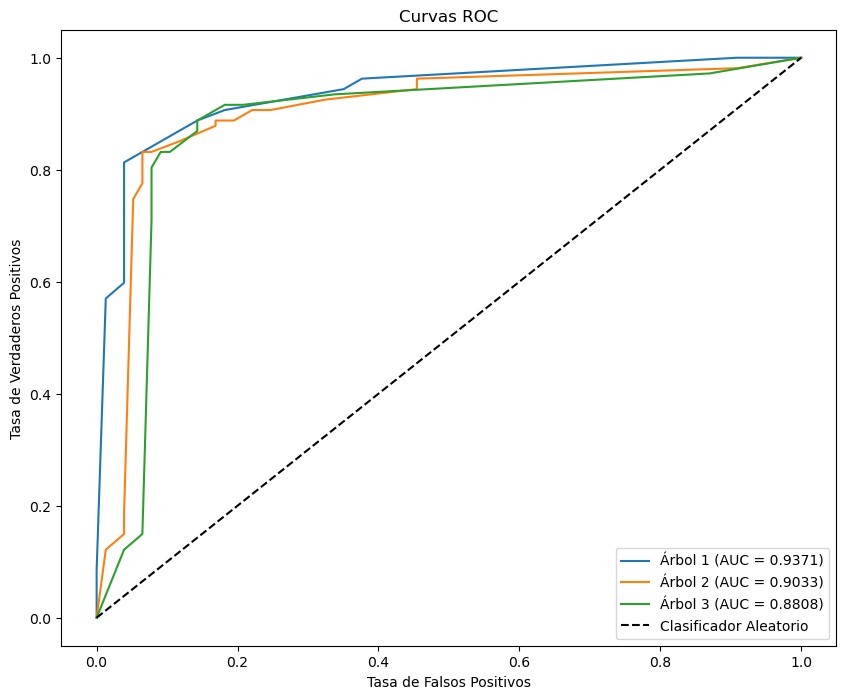

In [52]:
# Calcular y representar las curvas ROC para cada modelo
plt.figure(figsize=(10, 8))
for modelo, nombre in zip(modelos, nombres_modelos):
    y_probs = modelo.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    plt.plot(fpr, tpr, label=f"{nombre} (AUC = {roc_auc_score(y_test, y_probs):.4f})")
plt.plot([0, 1], [0, 1], 'k--', label='Clasificador Aleatorio')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC')
plt.legend()
plt.show()

En este caso, se puede observar que:

- Los tres modelos muestran alta fiabilidad, con valores de AUC superiores a 0.8, lo que indica que discriminan bien entre verdaderos positivos y falsos positivos.

- Los hiperparámetros definidos para cada modelo han resultado adecuados, generando resultados relativamente similares entre ellos.

- Además, la métrica ROC AUC es especialmente útil para evaluar el rendimiento de los modelos, ya que permite analizar su capacidad de discriminación de manera global, más allá de una única precisión.



## Ajuste de hiperparámetros con GridSearchCV

In [53]:
param_grid = {
    'max_depth': [4, 5, 7, 10],
    'min_samples_split': [5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_leaf_nodes': [10, 15, 20, 25, 30]
}

grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=seed),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Mejores hiperparámetros:", grid_search.best_params_)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits
Mejores hiperparámetros: {'max_depth': 4, 'max_leaf_nodes': 15, 'min_samples_leaf': 4, 'min_samples_split': 5}


In [54]:
# Comparar con el primero modelo 
y_probs_inicial = dtc.predict_proba(X_test)[:, 1]
roc_auc_inicial = roc_auc_score(y_test, y_probs_inicial)

# Árbol optimizado
arbol_optimizado = grid_search.best_estimator_
y_probs_optimizado = arbol_optimizado.predict_proba(X_test)[:, 1]
roc_auc_optimizado = roc_auc_score(y_test, y_probs_optimizado)

print(f"Modelo inicial - ROC AUC: {roc_auc_inicial:.4f}")
print(f"Modelo optimizado - ROC AUC: {roc_auc_optimizado:.4f}")

Modelo inicial - ROC AUC: 0.7894
Modelo optimizado - ROC AUC: 0.9371


Podemos observar una mejora significativa en el ROC AUC tras la optimización de hiperparámetros utilizando GridSearchCV. En el primer modelo, el ROC AUC fue de 0.7894, mientras que en el modelo optimizado alcanzó un ROC AUC de 0.9122, indicando una mejor capacidad del modelo optimizado para distinguir entre las clases positivas y negativas.


## Random Forest

In [55]:
# Entrenar un RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=2,
    max_leaf_nodes=30,
    random_state=seed
)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_leaf_nodes=30, min_samples_leaf=2,
                       min_samples_split=10, random_state=42)

In [56]:
# Comprar con el árbol optimizado
y_probs_rf = rf.predict_proba(X_test)[:, 1]
roc_auc_rf = roc_auc_score(y_test, y_probs_rf)

print(f"Modelo optimizado - ROC AUC: {roc_auc_optimizado:.4f}")
print(f"Random Forest - ROC AUC: {roc_auc_rf:.4f}")

Modelo optimizado - ROC AUC: 0.9371
Random Forest - ROC AUC: 0.9388


### 1 árbol vs múltiples árboles

Random Forest combina múltiples árboles de decisión entrenados sobre submuestras de los datos y características, por lo que:

- Reduce la varianza, menos sobreajuste que un único árbol profundo.

- Es más robusto a ruido y outliers.

- Su rendimiento suele ser mejor que un árbol individual incluso sin optimizar hiperparámetros.

- Un árbol individual puede memorizar los datos de entrenamiento si es muy profundo (sobreajuste).

- Random Forest “promedia” las predicciones de muchos árboles, por lo que generaliza mejor.

In [57]:

# Evaluar el Random Forest mediante métricas de clasificación
print("Reporte de clasificación para el modelo Random Forest:")
y_pred_rf = rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

Reporte de clasificación para el modelo Random Forest:
              precision    recall  f1-score   support

           0       0.85      0.88      0.87        77
           1       0.91      0.89      0.90       107

    accuracy                           0.89       184
   macro avg       0.88      0.89      0.88       184
weighted avg       0.89      0.89      0.89       184



In [58]:
# Métricas AUC
print("Métricas AUC para el modelo Random Forest:")
print(f"ROC AUC: {roc_auc_rf:.4f}")

Métricas AUC para el modelo Random Forest:
ROC AUC: 0.9388


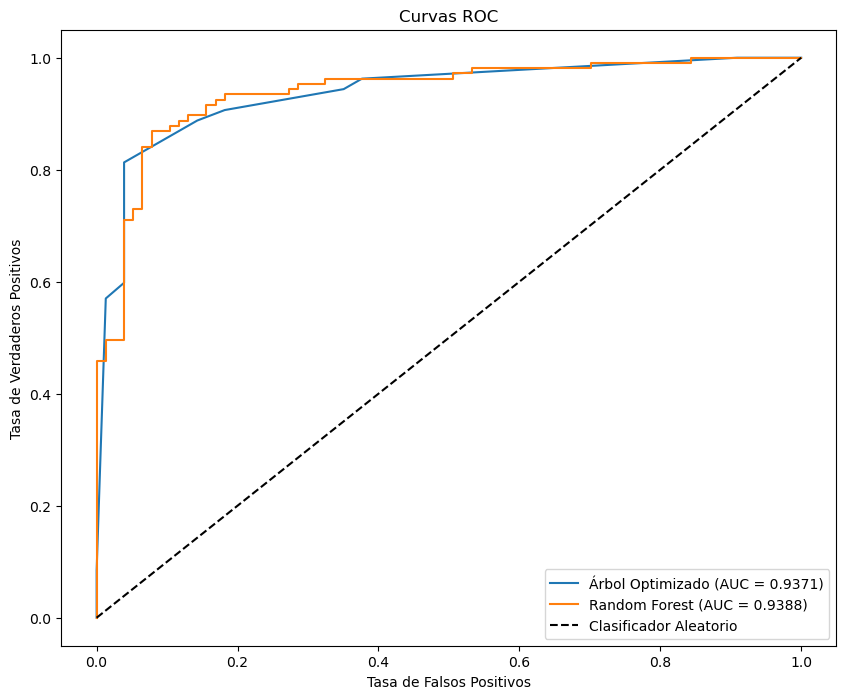

In [59]:
rf_y_arbol_optimizado = [arbol_optimizado, rf]
nombres_modelos_rf = ["Árbol Optimizado", "Random Forest"]

plt.figure(figsize=(10, 8))
for modelo, nombre in zip(rf_y_arbol_optimizado, nombres_modelos_rf):
    y_probs = modelo.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    plt.plot(fpr, tpr, label=f"{nombre} (AUC = {roc_auc_score(y_test, y_probs):.4f})")
plt.plot([0, 1], [0, 1], 'k--', label='Clasificador Aleatorio')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC')
plt.legend()
plt.show()

## Importancia de las variables

In [60]:
importancias = rf.feature_importances_
caracteristicas = X_train.columns

# DF para visualizar importancias
importancias_df = pd.DataFrame({
    'Característica': caracteristicas,
    'Importancia': importancias
}).sort_values(by='Importancia', ascending=False)

print(importancias_df)

    Característica  Importancia
10        ST_Slope     0.315001
8   ExerciseAngina     0.129015
9          Oldpeak     0.121097
2    ChestPainType     0.119671
4      Cholesterol     0.084744
7            MaxHR     0.079578
0              Age     0.053947
3        RestingBP     0.034596
1              Sex     0.034509
5        FastingBS     0.017727
6       RestingECG     0.010114


Según el RandomForest, las carácterísticas más importantes para predecir la cardiopatía son ST_Slope, ExerciseAngina, Oldpeak y ChestPainType. Estas variables están relacionadas con la actividad cardíaca y los síntomas experimentados por los pacientes, lo que tiene sentido desde una perspectiva médica.
    
- `ST_Slope`: **Pendiente del segmento ST** durante el ejercicio, que puede indicar isquemia.
- `ExerciseAngina`: Presencia de **angina inducida por el ejercicio**, un síntoma común en enfermedades cardíacas.
- `Oldpeak`: **Depresión del segmento ST inducida por el ejercicio**, que también puede indicar problemas cardíacos.
- `ChestPainType`: **Tipo de dolor en el pecho**, que es un síntoma clave en la evaluación de enfermedades cardíacas.

Otras características con menor peso en el modelo, como colesterol (Cholesterol), presión arterial en reposo (RestingBP), etc., pueden no ser tan predictivas en este conjunto de datos específico, pero esto no significa que no sean relevantes en un contexto clínico más amplio. 

## Regresión con árboles de decisión

In [61]:
# Primero, definimos una variable numérica objetivo (por ejemplo, la presión arterial)
df['RestingBP'] = df['RestingBP'].astype(float)

X_reg = df.drop("RestingBP", axis=1)
y_reg = df["RestingBP"]

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

dtr = DecisionTreeRegressor(random_state=42)
dtr.fit(X_train_reg, y_train_reg)

DecisionTreeRegressor(random_state=42)

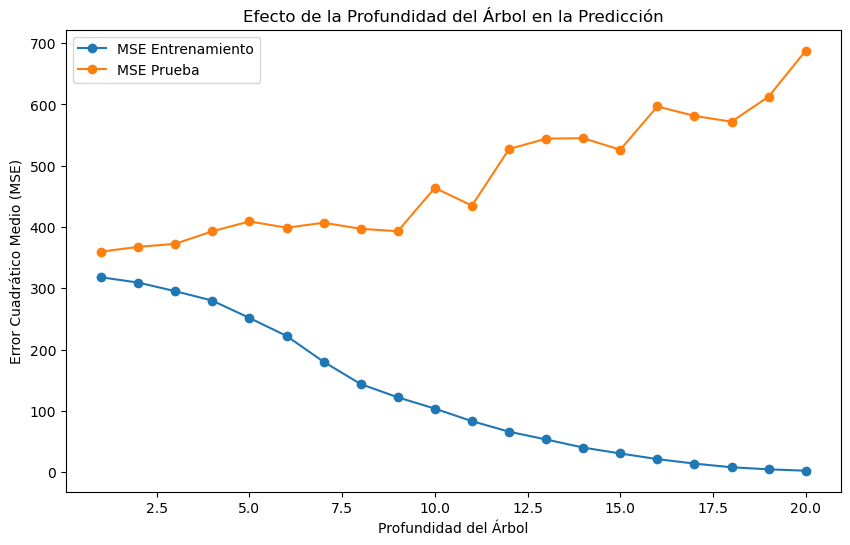

In [62]:
# Analizar el efecto de la profundidad del árbol en la predicción
depths = range(1, 21)
train_mse = []
test_mse = []

for depth in depths:
    dtr_temp = DecisionTreeRegressor(max_depth=depth, random_state=42)
    dtr_temp.fit(X_train_reg, y_train_reg)
    y_train_pred = dtr_temp.predict(X_train_reg)
    y_test_pred = dtr_temp.predict(X_test_reg)
    train_mse.append(np.mean((y_train_reg - y_train_pred) ** 2))
    test_mse.append(np.mean((y_test_reg - y_test_pred) ** 2))
    
plt.figure(figsize=(10, 6))
plt.plot(depths, train_mse, label='MSE Entrenamiento', marker='o')
plt.plot(depths, test_mse, label='MSE Prueba', marker='o')
plt.xlabel('Profundidad del Árbol')
plt.ylabel('Error Cuadrático Medio (MSE)')
plt.title('Efecto de la Profundidad del Árbol en la Predicción')
plt.legend()
plt.show()

In [63]:
# Convertir MSE a RMSE para otra interpretación
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
print(f"RMSE en Entrenamiento: {train_rmse}")
print(f"RMSE en Prueba: {test_rmse}")

RMSE en Entrenamiento: [17.83417181 17.59048945 17.18665583 16.73301565 15.86549889 14.9128147
 13.42595966 11.99411272 11.06008906 10.1887498   9.13513382  8.13755116
  7.31617133  6.3498476   5.54008218  4.63760982  3.76322596  2.86522042
  2.19887037  1.59978664]
RMSE en Prueba: [18.97051171 19.17558835 19.30417238 19.8264379  20.22931093 19.97264309
 20.17401218 19.92849422 19.82894805 21.53878325 20.85469019 22.95956443
 23.32921156 23.34360427 22.9374726  24.42782654 24.11066119 23.91301553
 24.75308279 26.22220338]


Según se puede observar en la gŕafica, podemos decudir que:

- MSE de Entrenamiento

        - Comienza alto (~300) con árboles muy poco profundos, el árbol no puede capturar bien la variabilidad de los datos resultando en un subajuste.

        - A medida que aumenta la profundidad, el MSE de entrenamiento disminuye constantemente hasta llegar a 0 con profundidad 20, el árbol memoriza los datos de entrenamiento.

- MSE de Prueba

        - Empieza alto (~350), el árbol poco profundo no predice bien.

        - Se mantiene relativamente estable hasta profundidad ~9, aquí el árbol equilibra ajuste y generalización.

        - A partir de profundidad 10 el MSE de prueba comienza a fluctuar aumentando constantemente hasta 700, en este punto el árbol está sobreajustando, capturando ruido en lugar de patrones generales.

        - Esto demuestra que más profundidad no siempre es mejor.

In [64]:
# Modelos con distinta regularización

# Comparar efectos de regularización en profundidad fija, comparamos Test MSE y Training MSE
params_list = [
    {'max_depth': 5, 'min_samples_leaf': 1},
    {'max_depth': 5, 'min_samples_leaf': 5},
    {'max_depth': 10, 'min_samples_leaf': 1},
    {'max_depth': 10, 'min_samples_leaf': 5},
]

for params in params_list:
    dtr_temp = DecisionTreeRegressor(
        max_depth=params['max_depth'],
        min_samples_leaf=params['min_samples_leaf'],
        random_state=42
    )
    dtr_temp.fit(X_train_reg, y_train_reg)
    y_train_pred = dtr_temp.predict(X_train_reg)
    y_test_pred = dtr_temp.predict(X_test_reg)
    train_mse = np.mean((y_train_reg - y_train_pred) ** 2)
    test_mse = np.mean((y_test_reg - y_test_pred) ** 2)
    print(f"Params: {params} - Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")
    
    # Mostramos también RMSE
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    print(f"Params: {params} - Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}\n")

Params: {'max_depth': 5, 'min_samples_leaf': 1} - Train MSE: 251.7141, Test MSE: 409.2250
Params: {'max_depth': 5, 'min_samples_leaf': 1} - Train RMSE: 15.8655, Test RMSE: 20.2293

Params: {'max_depth': 5, 'min_samples_leaf': 5} - Train MSE: 262.6092, Test MSE: 387.2976
Params: {'max_depth': 5, 'min_samples_leaf': 5} - Train RMSE: 16.2052, Test RMSE: 19.6799

Params: {'max_depth': 10, 'min_samples_leaf': 1} - Train MSE: 103.8106, Test MSE: 463.9192
Params: {'max_depth': 10, 'min_samples_leaf': 1} - Train RMSE: 10.1887, Test RMSE: 21.5388

Params: {'max_depth': 10, 'min_samples_leaf': 5} - Train MSE: 190.0387, Test MSE: 455.0275
Params: {'max_depth': 10, 'min_samples_leaf': 5} - Train RMSE: 13.7855, Test RMSE: 21.3314



## Aprendizaje conjunto: clasificador de votación

In [65]:
# Modelo que combine regresión logística, árboles de decisión y random forest
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression

voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(max_iter=1000, random_state=seed)),
        ('dt', DecisionTreeClassifier(max_depth=5, min_samples_leaf=2, random_state=seed)),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=seed))
    ],
    voting='soft'
)
voting_clf.fit(X_train, y_train)   

# Predecimos
y_pred_voting = voting_clf.predict(X_test)

In [66]:
from sklearn.metrics import roc_auc_score, accuracy_score

# Lista de modelos y nombres
modelos = [arbol1, arbol2, arbol3, arbol_optimizado, voting_clf]
nombres_modelos = ["Árbol 1", "Árbol 2", "Árbol 3", "Árbol Optimizado", "Voting Classifier"]

# Diccionarios para guardar métricas
roc_auc_dict = {}
accuracy_dict = {}

for modelo, nombre in zip(modelos, nombres_modelos):
    # Obtener probabilidades para ROC AUC
    y_probs = modelo.predict_proba(X_test)[:, 1]
    roc_auc_dict[nombre] = roc_auc_score(y_test, y_probs)
    
    # Obtener predicciones para accuracy
    y_pred = modelo.predict(X_test)
    accuracy_dict[nombre] = accuracy_score(y_test, y_pred)

# Crear tabla comparativa
comparacion = pd.DataFrame({
    'Modelo': nombres_modelos,
    'ROC AUC': [roc_auc_dict[n] for n in nombres_modelos],
    'Accuracy': [accuracy_dict[n] for n in nombres_modelos]
})

# Ordenar por ROC AUC descendente para que se vea quién rinde mejor
comparacion = comparacion.sort_values(by='ROC AUC', ascending=True).reset_index(drop=True)

print(comparacion)


              Modelo   ROC AUC  Accuracy
0            Árbol 3  0.880750  0.858696
1            Árbol 2  0.903265  0.869565
2            Árbol 1  0.937128  0.875000
3   Árbol Optimizado  0.937128  0.875000
4  Voting Classifier  0.937492  0.885870


Análisis de métricas ROC AUC y Accuracy:

- El `VotingClassifier` presenta el mejor resultado en comparación con los árboles individuales, al ponderar sus decisiones mediante probabilidades (`voting='soft'`).

- Esto muestra que un único árbol no siempre capta todos los patrones, mientras que el modelo combinado aprovecha mejor la información de varios modelos.

- Entre los árboles individuales, el Árbol 1 y el Árbol Optimizado muestran un ROC AUC idéntico (0.9371), superando a los otros árboles, aunque con una ligera diferencia en accuracy.

- La similitud entre el Árbol 1 y el modelo combinado puede explicarse por el hiperparámetro que controla la profundidad, que limita la complejidad del árbol y condiciona su rendimiento.